In [1]:
# Reference: https://spacetelescope.github.io/mast_notebooks/notebooks/TESS/beginner_how_to_use_lc/beginner_how_to_use_lc.html

from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
tess_bjds = []
pdcsap_fluxes = []

base_dir = '/Users/eligendreaudistler/Desktop/Berkeley_S26/wd-1856-534b/TESS_data/'
for filename in os.listdir(base_dir):
    filepath = os.path.join(base_dir, filename, f'{filename}_lc.fits')

    with fits.open(filepath, mode="readonly") as hdulist:
        tess_bjds.append(hdulist[1].data['TIME'])
        pdcsap_fluxes.append(hdulist[1].data['PDCSAP_FLUX'])

tess_bjds = np.concatenate(tess_bjds)
pdcsap_fluxes = np.concatenate(pdcsap_fluxes)

In [4]:
sort_idx = np.argsort(tess_bjds)
tess_bjds = tess_bjds[sort_idx]
pdcsap_fluxes = pdcsap_fluxes[sort_idx]

valid_mask = ~np.isnan(tess_bjds) & ~np.isnan(pdcsap_fluxes)
tess_bjds = tess_bjds[valid_mask]
pdcsap_fluxes = pdcsap_fluxes[valid_mask]

In [5]:
start_time = tess_bjds[0] + 2457000
end_time = tess_bjds[-1] + 2457000

#t0 = 2458779.3750828       # midtransit time from Vanderburg
t0 = 2459672.0085940000     # midtransit time from Nickel, seems to center TESS lightcurve better
P = 1.4079405

start_epoch = int((t0 - start_time) // P)
stop_epoch = int((t0 - end_time) // P)

transit_times = np.array([t0 - P*n - 2457000 for n in range(start_epoch, stop_epoch, -1)])

In [6]:
folded_times = tess_bjds % P
midtransit_time = (t0 - 2457000) % P
folded_times -= midtransit_time
folded_times *= 24 * 60 # convert days to minutes

In [ ]:
# two methods for averaging:
# - convolve replaces each point with the average of N adjacent points
# - downsample replaces each block of N points with the average of those points

def convolve(arr, N):
    return np.convolve(arr, np.ones(N)/N, mode='valid')

def downsample(arr, N):
    trimmed_arr = arr[:len(arr) // N * N]
    avg_arr = trimmed_arr.reshape(-1, N).mean(axis=1)
    return avg_arr

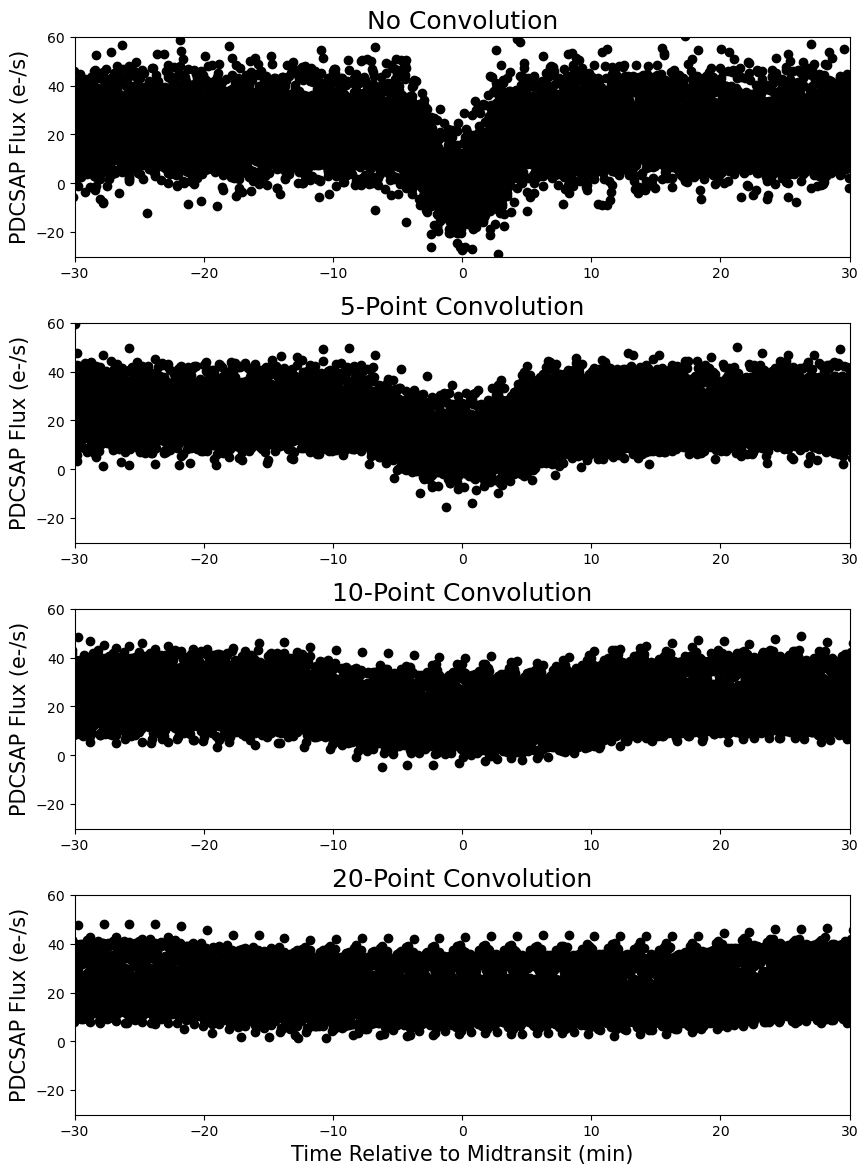

In [22]:
num_avg = [1, 5, 10, 20]

fig, axs = plt.subplots(4, 1, figsize=(10, 14))
plt.subplots_adjust(hspace=0.3)

for N, ax in zip(num_avg, axs):
    times = convolve(folded_times, N)
    fluxes = convolve(pdcsap_fluxes, N)

    ax.plot(times, fluxes, 'ko')

    ax.set_xlim(-30, 30)
    ax.set_ylim(-30, 60)
    ax.set_ylabel('PDCSAP Flux (e-/s)', fontsize=15)

    if N == 1:
        ax.set_title('No Convolution', fontsize=18)
    else:
        ax.set_title(f'{N}-Point Convolution', fontsize=18)

axs[-1].set_xlabel('Time Relative to Midtransit (min)', fontsize=15);

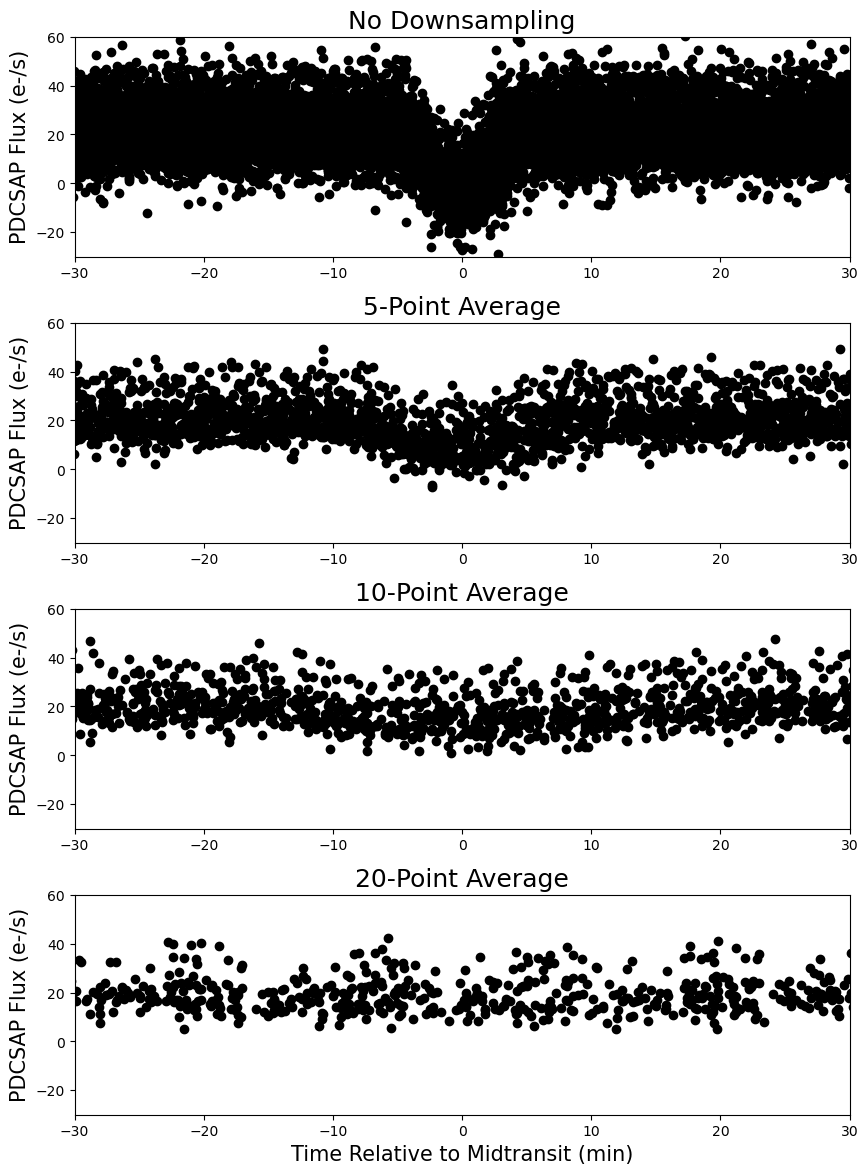

In [23]:
num_avg = [1, 5, 10, 20]

fig, axs = plt.subplots(4, 1, figsize=(10, 14))
plt.subplots_adjust(hspace=0.3)

for N, ax in zip(num_avg, axs):
    times = downsample(folded_times, N)
    fluxes = downsample(pdcsap_fluxes, N)

    ax.plot(times, fluxes, 'ko')

    ax.set_xlim(-30, 30)
    ax.set_ylim(-30, 60)
    ax.set_ylabel('PDCSAP Flux (e-/s)', fontsize=15)

    if N == 1:
        ax.set_title('No Downsampling', fontsize=18)
    else:
        ax.set_title(f'{N}-Point Average', fontsize=18)

axs[-1].set_xlabel('Time Relative to Midtransit (min)', fontsize=15);